In [1]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


## Load and Manipulate Data

### Load the data

In [2]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-01.csv', dtype = 'str')

cases_nyc_0409 = pd.read_csv('./zcta-history/2020-04-09.csv', dtype = 'str')
cases_nyc_0414 = pd.read_csv('./zcta-history/2020-04-14.csv', dtype = 'str')
cases_nyc_0421 = pd.read_csv('./zcta-history/2020-04-21.csv', dtype = 'str')
cases_nyc_0428 = pd.read_csv('./zcta-history/2020-04-28.csv', dtype = 'str')

### Combine and Manipulate the data

In [3]:
cases_nyc = cases_nyc.rename(columns={"Positive": "Positive_0401", "Total": "Total_0401", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0401"})

cases_nyc_0409 = cases_nyc_0409.rename(columns={"Positive": "Positive_0409", "Total": "Total_0409", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0409"})

cases_nyc_0414 = cases_nyc_0414.rename(columns={"Positive": "Positive_0414", "Total": "Total_0414", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0414"})

cases_nyc_0421 = cases_nyc_0421.rename(columns={"Positive": "Positive_0421", "Total": "Total_0421", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0421"})

cases_nyc_0428 = cases_nyc_0428.rename(columns={"Positive": "Positive_0428", "Total": "Total_0428", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0428"})

In [4]:
#Join together all the weekly cases data
cases_nyc = cases_nyc.merge(cases_nyc_0409, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0414, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0421, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0428, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [5]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [6]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [7]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)
        
#Divide by 100 for percents
# data.loc[:,"zcta_cum_perc_pos_0401"] = data.loc[:,"zcta_cum_perc_pos_0401"]/100.0
data.loc[:,"zcta_cum_perc_pos_0409"] = data.loc[:,"zcta_cum_perc_pos_0409"]/100.0
data.loc[:,"zcta_cum_perc_pos_0414"] = data.loc[:,"zcta_cum_perc_pos_0414"]/100.0
data.loc[:,"zcta_cum_perc_pos_0421"] = data.loc[:,"zcta_cum_perc_pos_0421"]/100.0
data.loc[:,"zcta_cum_perc_pos_0428"] = data.loc[:,"zcta_cum_perc_pos_0428"]/100.0


In [8]:
data.head()

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113.0,265.0,191.0,408.0,0.4681,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,253.0,597.0,0.4238,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,21.0,48.0,0.4375,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,36.0,108.0,0.3333,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


### Handle Null Values

In [9]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [10]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
148,11377,364.0,628.0,962.0,1425.0,0.6751,1214.0,1845.0,0.6580,1448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
167,11428,112.0,171.0,280.0,419.0,0.6683,382.0,597.0,0.6399,489.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


None of the columns with very common nulls seem too critical. We will exclude the columns with more than 10 nulls and for those with less than 10 nulls we will impute the value using the average.

In [11]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [12]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [13]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

pop_perc_some_college          0
pop_perc_hs                    0
pop_perc_under_hs              0
perc_transport_to_work_walk    0
beds                           0
dtype: int64

In [14]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

## Standardize the data

### Standardize the SES Covariates

In [15]:
#Exclude outcome variables
X = data.loc[:,"median_house_income":]

In [16]:
#Exclude a few covariates we decided against
X = X.drop(['perc_leave_for_work_12ato459',
       'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
       'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
       'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
       'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
       'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
       'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
       'perc_leave_for_work_4pto1159'], axis = 1)

In [17]:
X_cols = X.columns
#Set the scaler
X = preprocessing.StandardScaler().fit_transform(X)

### Standardize the outcome variable (disease burden)

First, we calculate the continuous cases per capita.

In [18]:
data

,MODZCTA,Positive_0401,Total_0401,Positive_0409,Total_0409,zcta_cum_perc_pos_0409,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113.0,265.0,191.0,408.0,0.4681,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,456.0,889.0,0.5129,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,253.0,597.0,0.4238,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,21.0,48.0,0.4375,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,36.0,108.0,0.3333,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,11691,436.0,694.0,941.0,1395.0,0.6746,1215.0,1792.0,0.6780,1543.0,...,0.067224,0.010110,0.006391,0.089942,0.087212,0.232642,0.041659,0.031550,0.059497,166.0
174,11692,110.0,184.0,246.0,379.0,0.6491,332.0,521.0,0.6372,399.0,...,0.047733,0.004714,0.022434,0.097375,0.113962,0.218138,0.036874,0.028819,0.020227,0.0
175,11693,86.0,144.0,167.0,274.0,0.6095,220.0,369.0,0.5962,262.0,...,0.042344,0.004185,0.003939,0.073855,0.097489,0.177991,0.046775,0.084934,0.032004,0.0
176,11694,143.0,270.0,302.0,519.0,0.5819,384.0,662.0,0.5801,475.0,...,0.065959,0.014914,0.014914,0.091021,0.050123,0.208948,0.056888,0.035055,0.067189,0.0


In [19]:
#Number of cases per capita - continuous
cases_per_10k = data[["Positive_0401","Positive_0409","Positive_0414","Positive_0421","Positive_0428","pop_total"]]

cases_per_10k.loc[:,"cases_per_10k_0401"] = 10000 * cases_per_10k.loc[:,"Positive_0401"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0409"] = 10000 * cases_per_10k.loc[:,"Positive_0409"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0414"] = 10000 * cases_per_10k.loc[:,"Positive_0414"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0421"] = 10000 * cases_per_10k.loc[:,"Positive_0421"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0428"] = 10000 * cases_per_10k.loc[:,"Positive_0428"] / \
    cases_per_10k.loc[:,"pop_total"]

/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


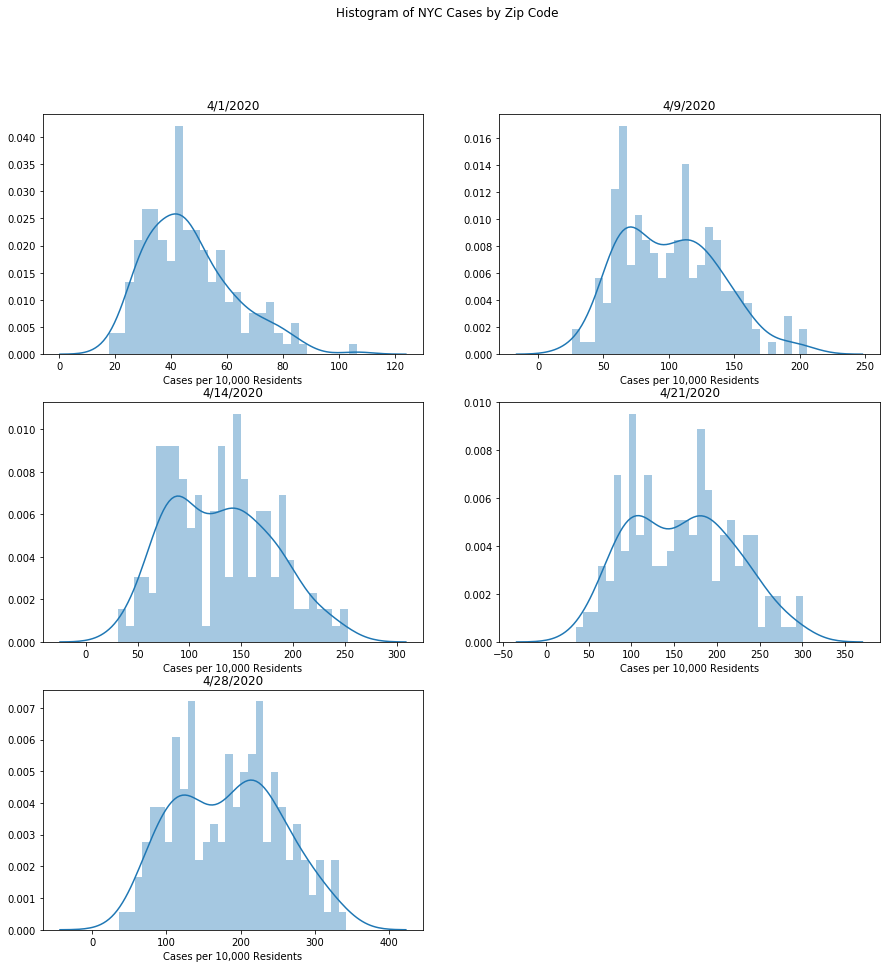

In [20]:
#Visualize the distribution of cases by zip
plt.figure(figsize = (15,15))
plt.suptitle("Histogram of NYC Cases by Zip Code")

plt.subplot(3,2,1)
sns.distplot(cases_per_10k.cases_per_10k_0401, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/1/2020")

plt.subplot(3,2,2)
sns.distplot(cases_per_10k.cases_per_10k_0409, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/9/2020")

plt.subplot(3,2,3)
sns.distplot(cases_per_10k.cases_per_10k_0414, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/14/2020")

plt.subplot(3,2,4)
sns.distplot(cases_per_10k.cases_per_10k_0421, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/21/2020")

plt.subplot(3,2,5)
sns.distplot(cases_per_10k.cases_per_10k_0428, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/28/2020")

plt.show();

We observe a distinct bimodal distribution. Notably, the modes spread farther apart over time. 

For 4/7/2020, our target date, we calculate the categories of cases per capita for the outcome variable for classifiers. We note from the distribution above that the "high" vs "low" risk area appears to occur around 75 cases per 10,000 residents.

In [20]:
y_categorical_0409 = np.zeros(len(cases_per_10k.cases_per_10k_0409))
y_categorical_0409 = y_categorical_0409.astype(str)

#Low
y_categorical_0409[cases_per_10k.cases_per_10k_0409 <= 85] = "Low"
#High
y_categorical_0409[cases_per_10k.cases_per_10k_0409 > 85] = "High"

pd.DataFrame(y_categorical_0409, columns = ['y']).groupby('y').size()

y
High    105
Low      72
dtype: int64

We will also investigate the presence of 3 clusters in the clustering analysis.

In [21]:
y_categorical_0409_3 = np.zeros(len(cases_per_10k.cases_per_10k_0409))
y_categorical_0409_3 = y_categorical_0409_3.astype(str)

#Low
y_categorical_0409_3[cases_per_10k.cases_per_10k_0409 <= 75] = "Low"
#Medium
y_categorical_0409_3[(cases_per_10k.cases_per_10k_0409 > 75) & (cases_per_10k.cases_per_10k_0409 <= 110)] = "Medium"
#High
y_categorical_0409_3[cases_per_10k.cases_per_10k_0409 > 110] = "High"

pd.DataFrame(y_categorical_0409_3, columns = ['y']).groupby('y').size()

y
High      73
Low       53
Medium    51
dtype: int64

## Clustering Analysis

### PCA and Preliminary Cluster Visualization

The bimodal distribution certainly seems to indicate that not all of these cases are coming from the same distribution and there are underlying factors that are differentiating these observations.

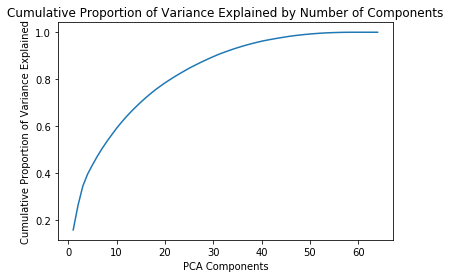

In [22]:
#Fit PCA
pca = PCA().fit(X)
X_pca = PCA().fit_transform(X)

#Plot Variance explained
plt.plot(list(range(1,len(pca.explained_variance_ratio_) + 1)), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Proportion of Variance Explained by Number of Components")
plt.xlabel("PCA Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show();

Even when looking just at the first two Principle Components, we can see clear clusters forming. These align quite clearly with the disease burden categories that we have identified.

### K Means - Raw Data

In [23]:
kmeans_fit_2 = KMeans(n_clusters = 2, n_init = 1, init = 'k-means++', random_state = 0).fit(X)
kmeans_fit_3 = KMeans(n_clusters = 3, n_init = 1, init = 'k-means++', random_state = 0).fit(X)

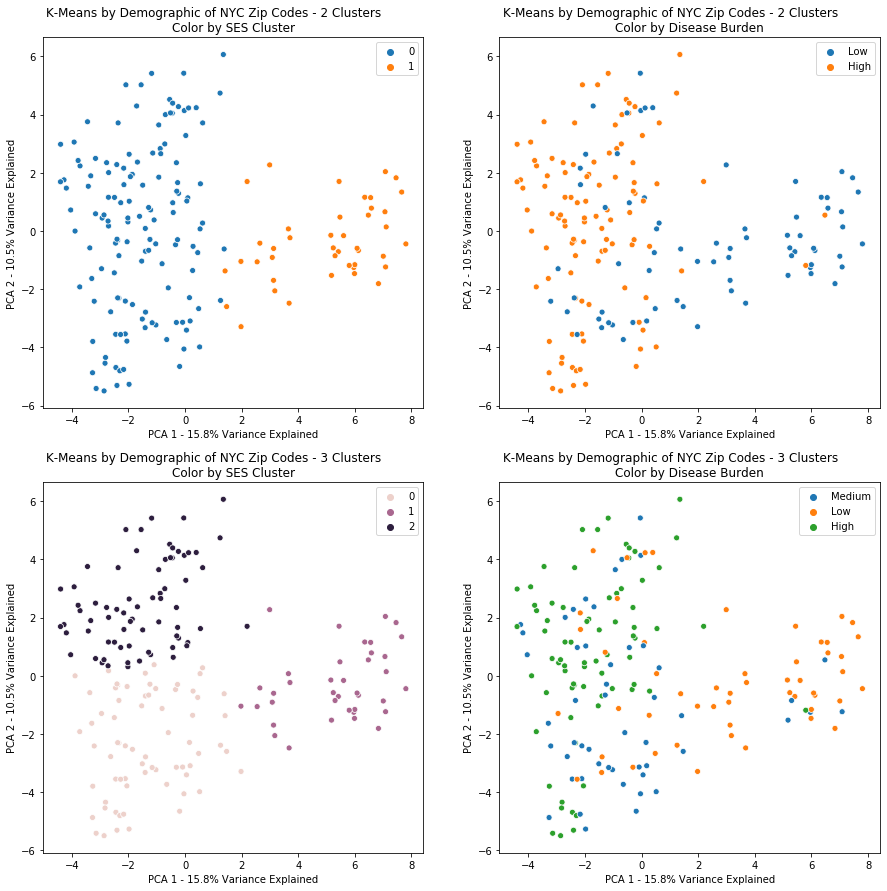

In [24]:
#Plot K Means
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409_3)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.show();

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(5,5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette analysis for KMeans clustering on sample data")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


For n_clusters = 2, the average silhouette_score is 0.1520336061833753.


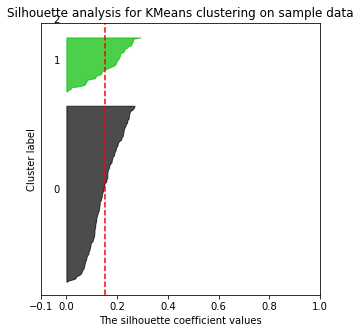

In [26]:
silplot(X, kmeans_fit_2.labels_, kmeans_fit_2, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.11075059169999896.


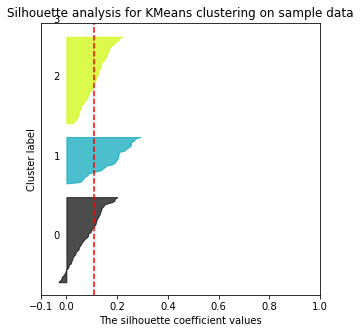

In [27]:
silplot(X, kmeans_fit_3.labels_, kmeans_fit_3, pointlabels=None)

The silhouette for n = 2 looks significantly better than the silhouette for n = 3. The average silhouette score is 0.195 vs 0.095.

### K Means - After PCA covering 95% of the variance

In [37]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15814218, 0.26340121, 0.34537396, 0.39665957, 0.43552636,
       0.47203798, 0.50533181, 0.53574625, 0.563979  , 0.59158796,
       0.61675639, 0.64035065, 0.66214178, 0.68265006, 0.70233769,
       0.72076449, 0.73824876, 0.75484548, 0.76984736, 0.78443439,
       0.79782127, 0.81083594, 0.82319527, 0.83506054, 0.84675789,
       0.85727751, 0.8675895 , 0.87746905, 0.88709446, 0.89611479,
       0.90496657, 0.91281362, 0.92024593, 0.92739631, 0.93409114,
       0.94042354, 0.94630019, 0.95176647, 0.95689147, 0.96178549,
       0.96594653, 0.96983425, 0.97343732, 0.9769029 , 0.98023998,
       0.98346635, 0.98602842, 0.98834387, 0.99060963, 0.99241291,
       0.99411185, 0.99566007, 0.99691566, 0.9978401 , 0.99858337,
       0.99920865, 0.99968766, 0.99987963, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [38]:
kmeans_fit_2_PCA = KMeans(n_clusters = 2, n_init = 1, init = 'k-means++', random_state = 0).fit(X_pca[:,:30])
kmeans_fit_3_PCA = KMeans(n_clusters = 3, n_init = 1, init = 'k-means++', random_state = 0).fit(X_pca[:,:30])

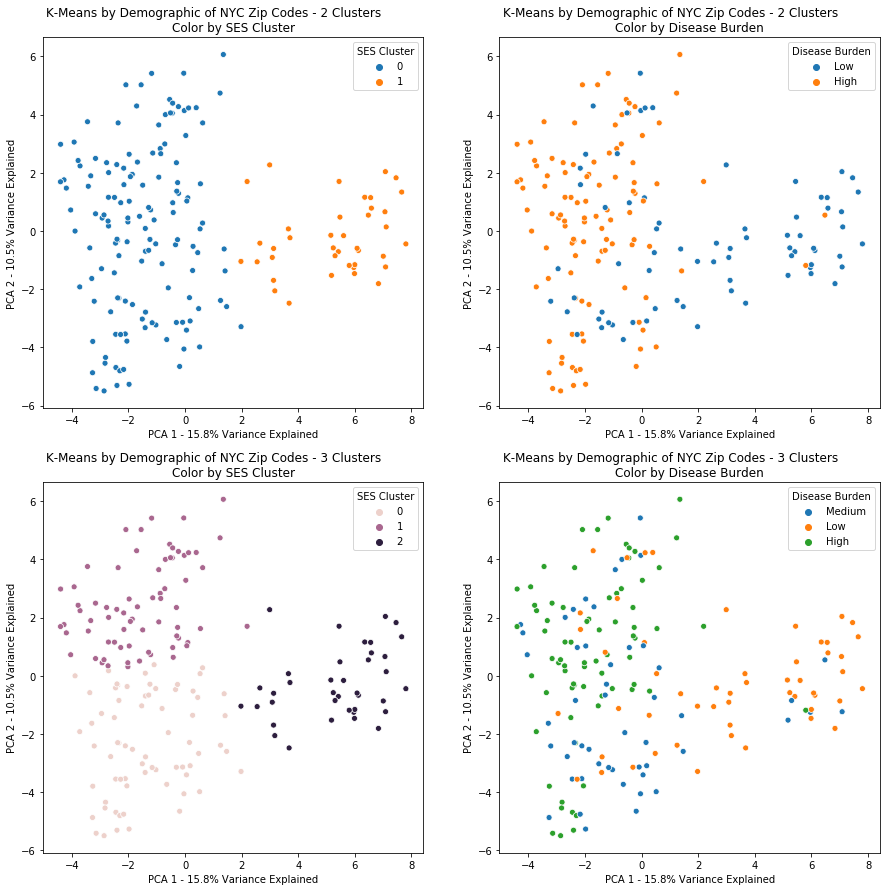

In [39]:
#Plot K Means
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "SES Cluster")

plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "Disease Burden")

plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by SES Cluster")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "SES Cluster")

plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical_0409_3)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.legend(title = "Disease Burden")

plt.show();

For n_clusters = 2, the average silhouette_score is 0.15468584446778263.


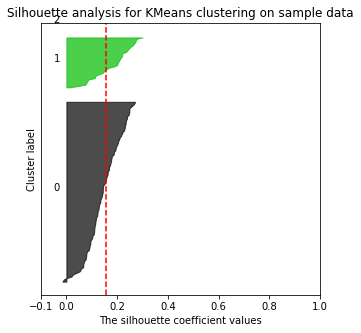

In [40]:
silplot(X, kmeans_fit_2_PCA.labels_, kmeans_fit_2_PCA, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.11075059169999896.


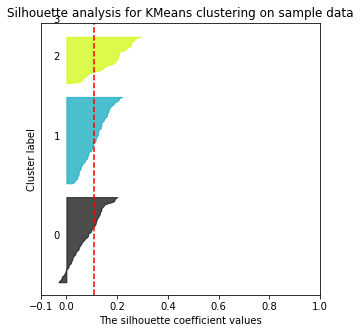

In [41]:
silplot(X, kmeans_fit_3_PCA.labels_, kmeans_fit_3_PCA, pointlabels=None)

Removing outliers through PCA has the result of discerning the cluster in the upper left hand side slightly better when n_clusters = 3, although the silhouette score is still lower for those categories compared to n_clusters = 2.

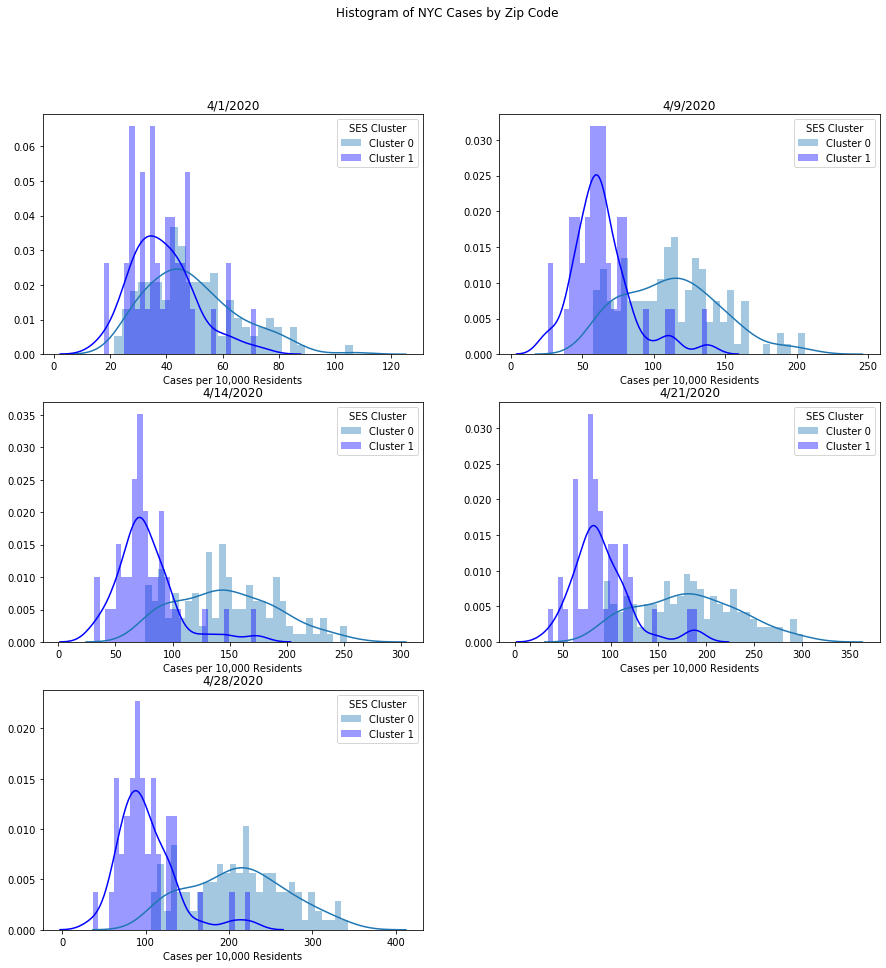

In [37]:
#Visualize the distribution of cases by zip and cluster
plt.figure(figsize = (15,15))
plt.suptitle("Histogram of NYC Cases by Zip Code")

plt.subplot(3,2,1)
sns.distplot(cases_per_10k.cases_per_10k_0401[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0401[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/1/2020")


plt.subplot(3,2,2)
sns.distplot(cases_per_10k.cases_per_10k_0409[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0409[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
# plt.axvline(x = 85)
plt.title("4/9/2020")

plt.subplot(3,2,3)
sns.distplot(cases_per_10k.cases_per_10k_0414[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0414[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/14/2020")

plt.subplot(3,2,4)
sns.distplot(cases_per_10k.cases_per_10k_0421[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0421[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/21/2020")

plt.subplot(3,2,5)
sns.distplot(cases_per_10k.cases_per_10k_0428[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k.cases_per_10k_0428[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.legend(title = "SES Cluster")
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/28/2020")

plt.show();



0.8248587570621468

In [73]:
y_categorical_0428 = np.zeros(len(cases_per_10k.cases_per_10k_0428))
y_categorical_0428 = y_categorical_0428.astype(str)

#Low
y_categorical_0428[cases_per_10k.cases_per_10k_0428 <= 150] = "Low"
#High
y_categorical_0428[cases_per_10k.cases_per_10k_0428 > 150] = "High"

pd.DataFrame(y_categorical_0428, columns = ['y']).groupby('y').size()

y
High    112
Low      65
dtype: int64

In [74]:
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state = 123).fit(X, y_categorical_0428)
rf.oob_score_

0.8531073446327684

## Lasso

In [39]:
Cs = np.logspace(-5, 5, 100)
tuned_parameters = [{'C': Cs}]
n_folds = 5

clf = GridSearchCV(LogisticRegression(random_state=0, tol = 0.1, solver = 'liblinear',penalty='l1'), tuned_parameters, 
                   cv=n_folds, refit=False, scoring = 'accuracy')
clf.fit(pd.DataFrame(X, columns = X_cols), y_categorical_0409)

/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=0, solver='liblinear',
                                          tol=0.1, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([1.0000000...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.

In [40]:
scores_logistic = clf.cv_results_['mean_test_score']
scores_std_logistic = clf.cv_results_['std_test_score']
clf.cv_results_["mean_test_score"]
best_C = list(clf.best_params_.values())
print("Best C is: " + str(best_C))

Best C is: [0.04328761281083057]


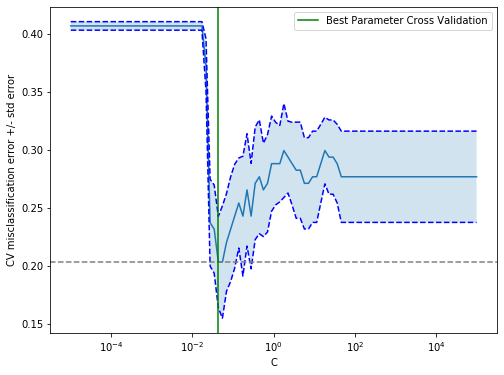

In [41]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(Cs, 1 - scores_logistic)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std_logistic / np.sqrt(n_folds)

plt.semilogx(Cs, 1 - scores_logistic + std_error, 'b--')
plt.semilogx(Cs, 1 - scores_logistic - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(Cs, 1 - scores_logistic + std_error, 1 - scores_logistic - std_error, alpha=0.2)

plt.ylabel('CV misclassification error +/- std error')
plt.xlabel('C')
plt.axhline(np.min(1-scores_logistic), linestyle='--', color='.5')
plt.axvline(x = best_C, color = "g", label = "Best Parameter Cross Validation")
plt.legend(loc = "best")

plt.show();

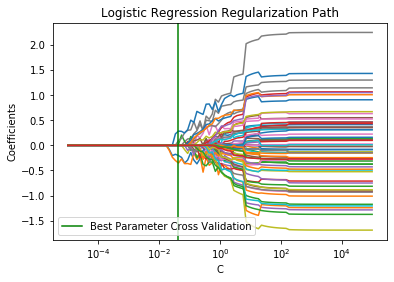

In [42]:
#cs = l1_min_c(X, y, loss='log') * np.logspace(-1, 5, 100)
cs = np.logspace(-5, 5, 100)

clf = LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=0.1, 
                                      warm_start=True,
                                      random_state=0)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(pd.DataFrame(X, columns = X_cols), y_categorical_0409)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(cs, coefs_)
plt.semilogx()
ymin, ymax = plt.ylim()
plt.xlabel('C')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Regularization Path')
plt.axis('tight')

plt.axvline(x = best_C, color = "g", label = "Best Parameter Cross Validation")
plt.legend(loc = "lower left")

plt.show();

In [49]:
best_lasso = LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=0.1, 
                                      warm_start=True,
                                      random_state=0, C = float(best_C[0]))

best_lasso.fit(pd.DataFrame(X, columns = X_cols), y_categorical_0409)

LogisticRegression(C=0.04328761281083057, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.1, verbose=0,
                   warm_start=True)

In [44]:
print("Min Logistic Score: " + str(best_lasso.score(pd.DataFrame(X, columns = X_cols), y_categorical_0409)))

Min Logistic Score: 0.8135593220338984


Take a look at the incorrect predictions:

In [45]:
np.sum(best_lasso.predict(X) != y_categorical_0409) / len(y_categorical_0409)

0.1864406779661017

In [47]:
y_categorical_0409[best_lasso.predict(X) != y_categorical_0409]

array(['High', 'High', 'Low', 'High', 'High', 'High', 'Low', 'High',
       'High', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low', 'High',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High'], dtype='<U32')

In [143]:
pd.DataFrame(X, columns = X_cols)[best_lasso.predict(X) != y_categorical_0409]
data[best_lasso.predict(X) != y_categorical_0409]

,MODZCTA,Positive_0401,Total_0401,Positive_0407,Total_0407,zcta_cum_perc_pos_0407,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
16,10018,66.0,151.0,116.0,251.0,0.4622,159.0,339.0,0.4690,169.0,...,0.058700,0.008386,0.006289,0.031447,0.035639,0.148847,0.023061,0.027254,0.064990,0.0
27,10030,106.0,204.0,186.0,329.0,0.5653,289.0,467.0,0.6188,360.0,...,0.096311,0.000000,0.004098,0.036885,0.034836,0.147541,0.022541,0.038934,0.022541,764.0
29,10032,308.0,548.0,508.0,857.0,0.5928,775.0,1262.0,0.6141,968.0,...,0.057361,0.015296,0.009560,0.022945,0.072658,0.143403,0.061185,0.034417,0.030593,0.0
32,10035,147.0,345.0,301.0,580.0,0.5190,475.0,852.0,0.5575,664.0,...,0.060514,0.007564,0.009077,0.059002,0.033283,0.130106,0.025719,0.063540,0.024206,0.0
36,10039,116.0,226.0,178.0,340.0,0.5235,277.0,504.0,0.5496,339.0,...,0.071627,0.007773,0.006108,0.044420,0.043865,0.242088,0.044975,0.027207,0.038312,0.0
41,10075,160.0,371.0,226.0,488.0,0.4631,274.0,581.0,0.4716,309.0,...,0.047085,0.002990,0.016442,0.044096,0.020927,0.159193,0.029148,0.032885,0.074738,422.0
77,10471,104.0,297.0,183.0,440.0,0.4159,319.0,716.0,0.4455,414.0,...,0.109091,0.000000,0.018182,0.000000,0.127273,0.109091,0.054545,0.000000,0.072727,0.0
84,11101,148.0,320.0,258.0,520.0,0.4962,364.0,707.0,0.5149,440.0,...,0.056181,0.011629,0.012610,0.103375,0.090916,0.202069,0.049536,0.028392,0.079061,0.0
95,11206,329.0,572.0,536.0,945.0,0.5672,808.0,1391.0,0.5809,1013.0,...,0.085246,0.010929,0.019672,0.077596,0.119126,0.151913,0.044809,0.061202,0.055738,238.0
96,11207,332.0,587.0,658.0,1087.0,0.6053,1004.0,1626.0,0.6175,1306.0,...,0.087152,0.012579,0.005391,0.070081,0.056604,0.176999,0.030548,0.044924,0.057502,0.0
